## MODEL Building

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
import joblib

In [72]:
X_train = pd.read_csv('X_train_pca.csv')  # PCA or scaled
X_test = pd.read_csv('X_test_pca.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [73]:
X_train = X_train.reindex(columns=X_test.columns).fillna(0).replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(0).replace([np.inf, -np.inf], 0)
y_train = np.asarray(y_train).ravel()
y_test = np.asarray(y_test).ravel()

print("Fixed—rerun models now.")

Fixed—rerun models now.


# LOGISTIC REGRESSION

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [75]:
lr_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [76]:
param_grid_lr = {'model__C': [0.01, 0.1, 1, 10, 100], 'model__solver': ['liblinear', 'lbfgs','saga']}
grid_lr = GridSearchCV(lr_pipe, param_grid_lr, cv=5, scoring='f1_macro', verbose=1,n_jobs=-1)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__solver': ['liblinear', 'lbfgs', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [77]:
grid_lr.best_params_

{'model__C': 100, 'model__solver': 'liblinear'}

In [78]:
grid_lr.best_score_

np.float64(0.618058237635891)

In [79]:
y_pred_lr = grid_lr.predict(X_test)
y_proba_lr = grid_lr.predict_proba(X_test)[:, 1]

In [80]:
print("Test Report:\n", classification_report(y_test, y_pred_lr))
print(f"AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")
    

Test Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.63       604
           1       0.49      0.75      0.59       363

    accuracy                           0.61       967
   macro avg       0.63      0.64      0.61       967
weighted avg       0.67      0.61      0.61       967

AUC: 0.696


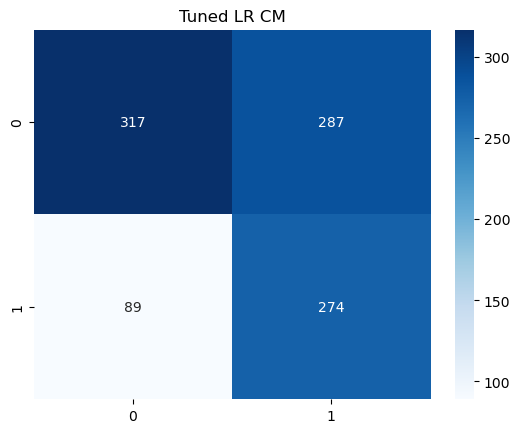

In [81]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Tuned LR CM')
plt.show()

In [82]:
joblib.dump(grid_lr, 'tuned_lr_smote.pkl')

['tuned_lr_smote.pkl']

# Random Forest

In [83]:
rf_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

In [84]:
param_grid_rf = {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5]}
grid_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [85]:
grid_rf.best_params_

{'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [86]:
grid_rf.best_score_

np.float64(0.6532515272628316)

In [87]:
y_pred_rf = grid_rf.predict(X_test)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

In [88]:
print("Test Report:\n", classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")

Test Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       604
           1       0.57      0.65      0.60       363

    accuracy                           0.68       967
   macro avg       0.67      0.68      0.67       967
weighted avg       0.69      0.68      0.69       967

AUC: 0.753


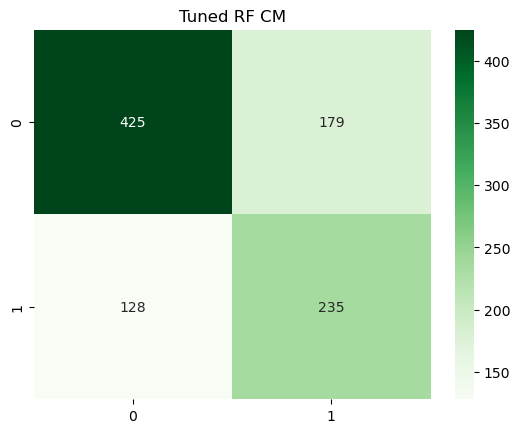

In [89]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Tuned RF CM')
plt.show()

In [90]:
joblib.dump(grid_rf, 'tuned_rf_smote.pkl')

['tuned_rf_smote.pkl']

# XGBOOST CLASSIFIER

In [91]:
from xgboost import XGBClassifier

In [92]:
scale_pos = len(y_train[y_train==0]) / len(y_train[y_train==1]) if len(y_train[y_train==1]) > 0 else 1

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [94]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', XGBClassifier(**params, random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos))
    ])
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    return cv_scores.mean()

In [95]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best Params: {study.best_params}")
print(f"Best CV F1: {study.best_value:.3f}")


[I 2025-10-03 12:27:26,102] A new study created in memory with name: no-name-c7814a0b-f425-458a-848e-92379c742aaa
Best trial: 0. Best value: 0.638611:   1%|          | 1/100 [00:01<01:55,  1.17s/it]

[I 2025-10-03 12:27:27,267] Trial 0 finished with value: 0.6386108898197931 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.1005534523763518, 'subsample': 0.689329215872612, 'colsample_bytree': 0.9776068075193111, 'gamma': 0.48550324668682227, 'reg_alpha': 0.6616510506095652, 'reg_lambda': 0.044693010693170665}. Best is trial 0 with value: 0.6386108898197931.


Best trial: 0. Best value: 0.638611:   2%|▏         | 2/100 [00:02<01:43,  1.06s/it]

[I 2025-10-03 12:27:28,254] Trial 1 finished with value: 0.6378282839255313 and parameters: {'n_estimators': 436, 'max_depth': 10, 'learning_rate': 0.1982416496230759, 'subsample': 0.9008290152651529, 'colsample_bytree': 0.7108646341763318, 'gamma': 0.42381164184758746, 'reg_alpha': 0.9939163791650533, 'reg_lambda': 0.3642211407158229}. Best is trial 0 with value: 0.6386108898197931.


Best trial: 2. Best value: 0.644344:   3%|▎         | 3/100 [00:03<02:12,  1.36s/it]

[I 2025-10-03 12:27:29,981] Trial 2 finished with value: 0.6443440340149486 and parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.15878347912210555, 'subsample': 0.6752376495347683, 'colsample_bytree': 0.7727432649481498, 'gamma': 0.02444655479480229, 'reg_alpha': 0.9509031418897828, 'reg_lambda': 0.8780311997561092}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   4%|▍         | 4/100 [00:04<01:49,  1.14s/it]

[I 2025-10-03 12:27:30,782] Trial 3 finished with value: 0.5892195235972031 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.018394074410736146, 'subsample': 0.7627177127692388, 'colsample_bytree': 0.7611485719131247, 'gamma': 0.21231355323675322, 'reg_alpha': 0.3734955752633352, 'reg_lambda': 0.5224656268322331}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   5%|▌         | 5/100 [00:05<01:30,  1.05it/s]

[I 2025-10-03 12:27:31,402] Trial 4 finished with value: 0.6339399562395348 and parameters: {'n_estimators': 479, 'max_depth': 6, 'learning_rate': 0.20191741346202832, 'subsample': 0.8585559935025728, 'colsample_bytree': 0.7617240162675886, 'gamma': 0.4718565089214927, 'reg_alpha': 0.023321672835961538, 'reg_lambda': 0.5138837919951703}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   6%|▌         | 6/100 [00:06<01:26,  1.09it/s]

[I 2025-10-03 12:27:32,246] Trial 5 finished with value: 0.6415230270290302 and parameters: {'n_estimators': 117, 'max_depth': 12, 'learning_rate': 0.06628466538963279, 'subsample': 0.7644404145497865, 'colsample_bytree': 0.7042445657780549, 'gamma': 0.09155779140642889, 'reg_alpha': 0.08982583374380271, 'reg_lambda': 0.8438106508379295}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   7%|▋         | 7/100 [00:06<01:21,  1.14it/s]

[I 2025-10-03 12:27:33,040] Trial 6 finished with value: 0.6322289632821892 and parameters: {'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.2581150762798236, 'subsample': 0.6798733018245433, 'colsample_bytree': 0.7730074633448765, 'gamma': 0.1479563789760398, 'reg_alpha': 0.7738286586048998, 'reg_lambda': 0.20494310218610434}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   8%|▊         | 8/100 [00:07<01:02,  1.48it/s]

[I 2025-10-03 12:27:33,285] Trial 7 finished with value: 0.6124756492517984 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.27064131846139694, 'subsample': 0.9023540397130734, 'colsample_bytree': 0.8880502076891528, 'gamma': 0.42608450557181465, 'reg_alpha': 0.21814969977762522, 'reg_lambda': 0.1160332515800786}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:   9%|▉         | 9/100 [00:07<00:56,  1.60it/s]

[I 2025-10-03 12:27:33,801] Trial 8 finished with value: 0.6138812880699526 and parameters: {'n_estimators': 458, 'max_depth': 3, 'learning_rate': 0.15464200248300547, 'subsample': 0.9187188318591063, 'colsample_bytree': 0.9685945350273155, 'gamma': 0.31359555982857235, 'reg_alpha': 0.9281796069363001, 'reg_lambda': 0.4569841415647127}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  10%|█         | 10/100 [00:07<00:45,  1.96it/s]

[I 2025-10-03 12:27:34,055] Trial 9 finished with value: 0.6072480968659831 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.2843039363731733, 'subsample': 0.9961161125550616, 'colsample_bytree': 0.7717829637495397, 'gamma': 0.054881914779551344, 'reg_alpha': 0.7208896752471973, 'reg_lambda': 0.32308744329065653}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  11%|█         | 11/100 [00:08<00:49,  1.81it/s]

[I 2025-10-03 12:27:34,700] Trial 10 finished with value: 0.6335623650985196 and parameters: {'n_estimators': 361, 'max_depth': 6, 'learning_rate': 0.12614353657009417, 'subsample': 0.606774033602516, 'colsample_bytree': 0.6122882260415197, 'gamma': 0.024129775999897102, 'reg_alpha': 0.48111697639077583, 'reg_lambda': 0.9258976928798629}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  12%|█▏        | 12/100 [00:10<01:15,  1.17it/s]

[I 2025-10-03 12:27:36,249] Trial 11 finished with value: 0.6381082881232819 and parameters: {'n_estimators': 281, 'max_depth': 12, 'learning_rate': 0.05399396710161464, 'subsample': 0.7563967007901036, 'colsample_bytree': 0.664523883894822, 'gamma': 0.11188765166475911, 'reg_alpha': 0.03684065655623453, 'reg_lambda': 0.9356746359495872}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  13%|█▎        | 13/100 [00:10<01:12,  1.19it/s]

[I 2025-10-03 12:27:37,052] Trial 12 finished with value: 0.6390281506323762 and parameters: {'n_estimators': 107, 'max_depth': 11, 'learning_rate': 0.08385404918249949, 'subsample': 0.6993369595292939, 'colsample_bytree': 0.8495284441730215, 'gamma': 0.008179111535155784, 'reg_alpha': 0.2402489022093953, 'reg_lambda': 0.7579630616483473}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  14%|█▍        | 14/100 [00:12<01:17,  1.10it/s]

[I 2025-10-03 12:27:38,111] Trial 13 finished with value: 0.6388141188780618 and parameters: {'n_estimators': 363, 'max_depth': 10, 'learning_rate': 0.19811726873001995, 'subsample': 0.6098586146954454, 'colsample_bytree': 0.6892308808454812, 'gamma': 0.12915637196147936, 'reg_alpha': 0.5605722138616838, 'reg_lambda': 0.7339466511977971}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  15%|█▌        | 15/100 [00:14<01:50,  1.31s/it]

[I 2025-10-03 12:27:40,343] Trial 14 finished with value: 0.6304036058431655 and parameters: {'n_estimators': 353, 'max_depth': 10, 'learning_rate': 0.011251313324892181, 'subsample': 0.8166633635120404, 'colsample_bytree': 0.8387771162886374, 'gamma': 0.24618249681280327, 'reg_alpha': 0.21788427860960058, 'reg_lambda': 0.7368884328770362}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  16%|█▌        | 16/100 [00:15<01:40,  1.20s/it]

[I 2025-10-03 12:27:41,286] Trial 15 finished with value: 0.6350250932438962 and parameters: {'n_estimators': 242, 'max_depth': 12, 'learning_rate': 0.14736102755136374, 'subsample': 0.7407413006070878, 'colsample_bytree': 0.6099625168911607, 'gamma': 0.08045622731032324, 'reg_alpha': 0.8448300592196952, 'reg_lambda': 0.8344483470145838}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 2. Best value: 0.644344:  17%|█▋        | 17/100 [00:16<01:42,  1.24s/it]

[I 2025-10-03 12:27:42,622] Trial 16 finished with value: 0.6379212048677612 and parameters: {'n_estimators': 404, 'max_depth': 8, 'learning_rate': 0.06711607410176655, 'subsample': 0.6478494570581845, 'colsample_bytree': 0.720944105799962, 'gamma': 0.17493942392710357, 'reg_alpha': 0.3722892378617845, 'reg_lambda': 0.6113606687152388}. Best is trial 2 with value: 0.6443440340149486.


Best trial: 17. Best value: 0.645274:  18%|█▊        | 18/100 [00:17<01:26,  1.06s/it]

[I 2025-10-03 12:27:43,261] Trial 17 finished with value: 0.6452738574746831 and parameters: {'n_estimators': 247, 'max_depth': 11, 'learning_rate': 0.23778247672425623, 'subsample': 0.8044306045615192, 'colsample_bytree': 0.837027059135588, 'gamma': 0.31349740549330557, 'reg_alpha': 0.5847757057706813, 'reg_lambda': 0.9978051720901187}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s]

[I 2025-10-03 12:27:43,813] Trial 18 finished with value: 0.6364714737041386 and parameters: {'n_estimators': 246, 'max_depth': 6, 'learning_rate': 0.22844104823138522, 'subsample': 0.8171269151221584, 'colsample_bytree': 0.9040139391919693, 'gamma': 0.3276075393848002, 'reg_alpha': 0.6161879405432036, 'reg_lambda': 0.997576110427755}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  20%|██        | 20/100 [00:18<01:04,  1.24it/s]

[I 2025-10-03 12:27:44,385] Trial 19 finished with value: 0.6381467622896297 and parameters: {'n_estimators': 321, 'max_depth': 9, 'learning_rate': 0.2406084894309197, 'subsample': 0.8504209503275779, 'colsample_bytree': 0.827896864796636, 'gamma': 0.30756474501778613, 'reg_alpha': 0.8756149198741527, 'reg_lambda': 0.6553506937217655}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  21%|██        | 21/100 [00:19<01:03,  1.24it/s]

[I 2025-10-03 12:27:45,188] Trial 20 finished with value: 0.6375071824688461 and parameters: {'n_estimators': 235, 'max_depth': 11, 'learning_rate': 0.1690810882311109, 'subsample': 0.7162634513222352, 'colsample_bytree': 0.9072108222711022, 'gamma': 0.39305537087658415, 'reg_alpha': 0.48837634673838853, 'reg_lambda': 0.9878842220686151}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  22%|██▏       | 22/100 [00:19<01:01,  1.27it/s]

[I 2025-10-03 12:27:45,931] Trial 21 finished with value: 0.6383141441982182 and parameters: {'n_estimators': 113, 'max_depth': 11, 'learning_rate': 0.1312231861359174, 'subsample': 0.7855010207202247, 'colsample_bytree': 0.7994305490395497, 'gamma': 0.05622322575329443, 'reg_alpha': 0.37310226186582895, 'reg_lambda': 0.8585655500951844}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  23%|██▎       | 23/100 [00:20<00:55,  1.38it/s]

[I 2025-10-03 12:27:46,514] Trial 22 finished with value: 0.6389242096903156 and parameters: {'n_estimators': 152, 'max_depth': 11, 'learning_rate': 0.17984733747832754, 'subsample': 0.6627725762584792, 'colsample_bytree': 0.6587174646041236, 'gamma': 0.2715697897907621, 'reg_alpha': 0.1516509068979212, 'reg_lambda': 0.8289541747660277}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  24%|██▍       | 24/100 [00:21<01:03,  1.20it/s]

[I 2025-10-03 12:27:47,598] Trial 23 finished with value: 0.6390947536668479 and parameters: {'n_estimators': 310, 'max_depth': 9, 'learning_rate': 0.10713042710839815, 'subsample': 0.7253003682313157, 'colsample_bytree': 0.7321778989112252, 'gamma': 0.18922605523702743, 'reg_alpha': 0.7737286451857263, 'reg_lambda': 0.9003153435404199}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  25%|██▌       | 25/100 [00:23<01:24,  1.13s/it]

[I 2025-10-03 12:27:49,404] Trial 24 finished with value: 0.6409708583813934 and parameters: {'n_estimators': 270, 'max_depth': 12, 'learning_rate': 0.03782626214227311, 'subsample': 0.8560652144709517, 'colsample_bytree': 0.806879591634368, 'gamma': 0.09781569667206279, 'reg_alpha': 0.30677945755017344, 'reg_lambda': 0.6426196834473729}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  26%|██▌       | 26/100 [00:24<01:26,  1.16s/it]

[I 2025-10-03 12:27:50,659] Trial 25 finished with value: 0.6377354840627012 and parameters: {'n_estimators': 332, 'max_depth': 10, 'learning_rate': 0.23216063809259369, 'subsample': 0.7872434248688351, 'colsample_bytree': 0.8704890611498703, 'gamma': 0.00034949059680401684, 'reg_alpha': 0.11063978273903803, 'reg_lambda': 0.7951500694033227}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  27%|██▋       | 27/100 [00:25<01:16,  1.05s/it]

[I 2025-10-03 12:27:51,454] Trial 26 finished with value: 0.6347597085721348 and parameters: {'n_estimators': 403, 'max_depth': 7, 'learning_rate': 0.12005119755138753, 'subsample': 0.7672839078651021, 'colsample_bytree': 0.6475070778960489, 'gamma': 0.34869723734076735, 'reg_alpha': 0.5822686606411567, 'reg_lambda': 0.9997608465002717}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  28%|██▊       | 28/100 [00:26<01:11,  1.00it/s]

[I 2025-10-03 12:27:52,328] Trial 27 finished with value: 0.6418169134575882 and parameters: {'n_estimators': 210, 'max_depth': 11, 'learning_rate': 0.17554696493822378, 'subsample': 0.640783041960702, 'colsample_bytree': 0.9304977846408534, 'gamma': 0.24750289390985653, 'reg_alpha': 0.42722519672832765, 'reg_lambda': 0.8747672964087655}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  29%|██▉       | 29/100 [00:26<01:05,  1.08it/s]

[I 2025-10-03 12:27:53,072] Trial 28 finished with value: 0.6378461606168238 and parameters: {'n_estimators': 211, 'max_depth': 9, 'learning_rate': 0.21421627387873307, 'subsample': 0.6331320132943714, 'colsample_bytree': 0.9395371409352845, 'gamma': 0.2564121673970483, 'reg_alpha': 0.4587855078441582, 'reg_lambda': 0.7095634517086815}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  30%|███       | 30/100 [00:27<01:01,  1.14it/s]

[I 2025-10-03 12:27:53,835] Trial 29 finished with value: 0.6372300318882982 and parameters: {'n_estimators': 171, 'max_depth': 11, 'learning_rate': 0.1754559221949822, 'subsample': 0.6821486883428179, 'colsample_bytree': 0.9876574542494669, 'gamma': 0.3721835790768715, 'reg_alpha': 0.6697368180189791, 'reg_lambda': 0.9400256316899807}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  31%|███       | 31/100 [00:28<00:56,  1.22it/s]

[I 2025-10-03 12:27:54,536] Trial 30 finished with value: 0.6352831605379107 and parameters: {'n_estimators': 271, 'max_depth': 8, 'learning_rate': 0.29673027228245397, 'subsample': 0.6333574287336691, 'colsample_bytree': 0.9645555376255909, 'gamma': 0.21473024672602442, 'reg_alpha': 0.6565260952546558, 'reg_lambda': 0.5825343134784771}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  32%|███▏      | 32/100 [00:29<00:59,  1.14it/s]

[I 2025-10-03 12:27:55,553] Trial 31 finished with value: 0.6450040770425923 and parameters: {'n_estimators': 139, 'max_depth': 12, 'learning_rate': 0.09412558093085105, 'subsample': 0.7062146780325111, 'colsample_bytree': 0.9310785570889171, 'gamma': 0.051800818942860066, 'reg_alpha': 0.1182435693749614, 'reg_lambda': 0.8756297069889987}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  33%|███▎      | 33/100 [00:30<01:01,  1.09it/s]

[I 2025-10-03 12:27:56,549] Trial 32 finished with value: 0.643081600001529 and parameters: {'n_estimators': 161, 'max_depth': 10, 'learning_rate': 0.09479367504638858, 'subsample': 0.7037856103599166, 'colsample_bytree': 0.9193444622167061, 'gamma': 0.037514160492217244, 'reg_alpha': 0.9556041189376685, 'reg_lambda': 0.9086770216620887}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  34%|███▍      | 34/100 [00:31<00:59,  1.12it/s]

[I 2025-10-03 12:27:57,399] Trial 33 finished with value: 0.6418198155326533 and parameters: {'n_estimators': 136, 'max_depth': 10, 'learning_rate': 0.08845954089444416, 'subsample': 0.7034948834510031, 'colsample_bytree': 0.8664557993207448, 'gamma': 0.05969090479951053, 'reg_alpha': 0.9971909697064284, 'reg_lambda': 0.7925270484882226}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  35%|███▌      | 35/100 [00:32<00:57,  1.13it/s]

[I 2025-10-03 12:27:58,272] Trial 34 finished with value: 0.6428313543982678 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.1020763407705638, 'subsample': 0.7253415738394666, 'colsample_bytree': 0.8087960949062263, 'gamma': 0.033554027389060485, 'reg_alpha': 0.9258577687127472, 'reg_lambda': 0.916403053103159}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  36%|███▌      | 36/100 [00:32<00:55,  1.15it/s]

[I 2025-10-03 12:27:59,094] Trial 35 finished with value: 0.6429789623337677 and parameters: {'n_estimators': 180, 'max_depth': 9, 'learning_rate': 0.1384750355933227, 'subsample': 0.6696445304279481, 'colsample_bytree': 0.9335831996425629, 'gamma': 0.14204368602617815, 'reg_alpha': 0.825689809116689, 'reg_lambda': 0.6975197832416478}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  37%|███▋      | 37/100 [00:34<00:58,  1.07it/s]

[I 2025-10-03 12:28:00,180] Trial 36 finished with value: 0.6365256273178225 and parameters: {'n_estimators': 127, 'max_depth': 12, 'learning_rate': 0.04571138827501825, 'subsample': 0.745182127034903, 'colsample_bytree': 0.9988361596183195, 'gamma': 0.03370358966422943, 'reg_alpha': 0.9473869859173314, 'reg_lambda': 0.4332146313385333}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  38%|███▊      | 38/100 [00:34<00:52,  1.19it/s]

[I 2025-10-03 12:28:00,813] Trial 37 finished with value: 0.6337140122741471 and parameters: {'n_estimators': 253, 'max_depth': 7, 'learning_rate': 0.07592758924374757, 'subsample': 0.8352199847521687, 'colsample_bytree': 0.7453034457259837, 'gamma': 0.4758870505373388, 'reg_alpha': 0.7706109807696233, 'reg_lambda': 0.7883955062815724}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  39%|███▉      | 39/100 [00:35<00:41,  1.45it/s]

[I 2025-10-03 12:28:01,138] Trial 38 finished with value: 0.5707743364071399 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.02829919143841811, 'subsample': 0.694602228318792, 'colsample_bytree': 0.8933679751808339, 'gamma': 0.08175961929472796, 'reg_alpha': 0.8889172514181816, 'reg_lambda': 0.9542687464590287}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  40%|████      | 40/100 [00:36<00:46,  1.28it/s]

[I 2025-10-03 12:28:02,126] Trial 39 finished with value: 0.6436925406439968 and parameters: {'n_estimators': 296, 'max_depth': 10, 'learning_rate': 0.11139430697169095, 'subsample': 0.8891419294825365, 'colsample_bytree': 0.9489005877012792, 'gamma': 0.1583163424720786, 'reg_alpha': 0.5381456067520028, 'reg_lambda': 0.016070286103231357}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  41%|████      | 41/100 [00:36<00:41,  1.42it/s]

[I 2025-10-03 12:28:02,667] Trial 40 finished with value: 0.6393751378902148 and parameters: {'n_estimators': 292, 'max_depth': 11, 'learning_rate': 0.25821070515939676, 'subsample': 0.9451239406601404, 'colsample_bytree': 0.7866686459027038, 'gamma': 0.1922291518839892, 'reg_alpha': 0.5322170729770704, 'reg_lambda': 0.07468957782137459}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  42%|████▏     | 42/100 [00:37<00:47,  1.22it/s]

[I 2025-10-03 12:28:03,749] Trial 41 finished with value: 0.6426236978439379 and parameters: {'n_estimators': 345, 'max_depth': 10, 'learning_rate': 0.11328860553131426, 'subsample': 0.8822719640930679, 'colsample_bytree': 0.9534330220168334, 'gamma': 0.15690178862131887, 'reg_alpha': 0.6999492310379046, 'reg_lambda': 0.226473775712097}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  43%|████▎     | 43/100 [00:38<00:53,  1.06it/s]

[I 2025-10-03 12:28:04,978] Trial 42 finished with value: 0.6405073118315205 and parameters: {'n_estimators': 304, 'max_depth': 9, 'learning_rate': 0.09017832990368814, 'subsample': 0.9639627880219226, 'colsample_bytree': 0.9127597226190177, 'gamma': 0.0623830651141513, 'reg_alpha': 0.4186497680260433, 'reg_lambda': 0.3359896780499843}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  44%|████▍     | 44/100 [00:40<00:56,  1.00s/it]

[I 2025-10-03 12:28:06,122] Trial 43 finished with value: 0.6385041789363682 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.09923690843030646, 'subsample': 0.8784280110384289, 'colsample_bytree': 0.8698722309749893, 'gamma': 0.11637866713977477, 'reg_alpha': 0.9675238281456096, 'reg_lambda': 0.19540133429555495}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  45%|████▌     | 45/100 [00:40<00:50,  1.09it/s]

[I 2025-10-03 12:28:06,832] Trial 44 finished with value: 0.6340728058903663 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.06105200990374675, 'subsample': 0.936781276844073, 'colsample_bytree': 0.9225186782706596, 'gamma': 0.02611878779563774, 'reg_alpha': 0.6140712488965405, 'reg_lambda': 0.8761588930967962}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  46%|████▌     | 46/100 [00:41<00:47,  1.13it/s]

[I 2025-10-03 12:28:07,637] Trial 45 finished with value: 0.6418523878869056 and parameters: {'n_estimators': 385, 'max_depth': 11, 'learning_rate': 0.15273204218512063, 'subsample': 0.8084549003905773, 'colsample_bytree': 0.9600931641416398, 'gamma': 0.2859680289612652, 'reg_alpha': 0.5229733482333305, 'reg_lambda': 0.021276366768287147}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  47%|████▋     | 47/100 [00:42<00:45,  1.17it/s]

[I 2025-10-03 12:28:08,433] Trial 46 finished with value: 0.6337533619695503 and parameters: {'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.1930353008511253, 'subsample': 0.6594037820060844, 'colsample_bytree': 0.7551560124528691, 'gamma': 0.22290715482447987, 'reg_alpha': 0.7409729416651193, 'reg_lambda': 0.4407607782385625}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  48%|████▊     | 48/100 [00:43<00:46,  1.13it/s]

[I 2025-10-03 12:28:09,386] Trial 47 finished with value: 0.6389415505367474 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.11923941546092795, 'subsample': 0.9032772323293503, 'colsample_bytree': 0.9809199835843181, 'gamma': 0.10678444273782786, 'reg_alpha': 0.3237701244359937, 'reg_lambda': 0.9571061522088357}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  49%|████▉     | 49/100 [00:44<00:45,  1.11it/s]

[I 2025-10-03 12:28:10,318] Trial 48 finished with value: 0.6399418406543569 and parameters: {'n_estimators': 181, 'max_depth': 12, 'learning_rate': 0.1385574643937724, 'subsample': 0.7822529636357566, 'colsample_bytree': 0.8263685585276697, 'gamma': 0.07296704564680695, 'reg_alpha': 0.8335410297670618, 'reg_lambda': 0.2480423804413377}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  50%|█████     | 50/100 [00:46<00:58,  1.18s/it]

[I 2025-10-03 12:28:12,143] Trial 49 finished with value: 0.641641689449917 and parameters: {'n_estimators': 328, 'max_depth': 11, 'learning_rate': 0.07344431105224042, 'subsample': 0.8341109282445238, 'colsample_bytree': 0.9483319949651584, 'gamma': 0.04233856845553688, 'reg_alpha': 0.26823608840419183, 'reg_lambda': 0.5080054591200671}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  51%|█████     | 51/100 [00:46<00:50,  1.04s/it]

[I 2025-10-03 12:28:12,864] Trial 50 finished with value: 0.6442684288803482 and parameters: {'n_estimators': 287, 'max_depth': 10, 'learning_rate': 0.16033239491337292, 'subsample': 0.7099572139947713, 'colsample_bytree': 0.8863772575674399, 'gamma': 0.43731559692122873, 'reg_alpha': 0.012048360405255726, 'reg_lambda': 0.15931959989163108}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  52%|█████▏    | 52/100 [00:47<00:44,  1.07it/s]

[I 2025-10-03 12:28:13,545] Trial 51 finished with value: 0.6437606303813869 and parameters: {'n_estimators': 286, 'max_depth': 10, 'learning_rate': 0.2096876624802975, 'subsample': 0.7096636922014735, 'colsample_bytree': 0.8810488931919657, 'gamma': 0.40669945131580243, 'reg_alpha': 0.0831361184457288, 'reg_lambda': 0.1499897065272269}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  53%|█████▎    | 53/100 [00:48<00:40,  1.17it/s]

[I 2025-10-03 12:28:14,227] Trial 52 finished with value: 0.6392935138843772 and parameters: {'n_estimators': 283, 'max_depth': 10, 'learning_rate': 0.16555083026618433, 'subsample': 0.7417793214570086, 'colsample_bytree': 0.8861820068622968, 'gamma': 0.43938399788455995, 'reg_alpha': 0.06412280432490841, 'reg_lambda': 0.10571948606986692}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  54%|█████▍    | 54/100 [00:48<00:37,  1.22it/s]

[I 2025-10-03 12:28:14,955] Trial 53 finished with value: 0.6362669998542073 and parameters: {'n_estimators': 301, 'max_depth': 12, 'learning_rate': 0.20750561456790556, 'subsample': 0.7147606108888521, 'colsample_bytree': 0.887180351929458, 'gamma': 0.4463101381220458, 'reg_alpha': 0.022953382769116674, 'reg_lambda': 0.17609230317279348}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  55%|█████▌    | 55/100 [00:49<00:36,  1.24it/s]

[I 2025-10-03 12:28:15,730] Trial 54 finished with value: 0.6329904383189886 and parameters: {'n_estimators': 316, 'max_depth': 9, 'learning_rate': 0.18638211229057283, 'subsample': 0.6797188007939077, 'colsample_bytree': 0.8343576056293124, 'gamma': 0.40974778693739594, 'reg_alpha': 0.16582770758909915, 'reg_lambda': 0.14282619875604022}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  56%|█████▌    | 56/100 [00:50<00:35,  1.23it/s]

[I 2025-10-03 12:28:16,549] Trial 55 finished with value: 0.6416556423255824 and parameters: {'n_estimators': 339, 'max_depth': 11, 'learning_rate': 0.21940087945782877, 'subsample': 0.6169613195894769, 'colsample_bytree': 0.855841714828357, 'gamma': 0.3629428906881927, 'reg_alpha': 0.10725091129892522, 'reg_lambda': 0.00634251899035362}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  57%|█████▋    | 57/100 [00:50<00:31,  1.39it/s]

[I 2025-10-03 12:28:17,067] Trial 56 finished with value: 0.6404560697512067 and parameters: {'n_estimators': 229, 'max_depth': 10, 'learning_rate': 0.25386688238275723, 'subsample': 0.7656243641327438, 'colsample_bytree': 0.8499839983860462, 'gamma': 0.4959896268373148, 'reg_alpha': 0.1801031472536486, 'reg_lambda': 0.25771238878176245}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  58%|█████▊    | 58/100 [00:51<00:30,  1.36it/s]

[I 2025-10-03 12:28:17,839] Trial 57 finished with value: 0.6403859935474149 and parameters: {'n_estimators': 373, 'max_depth': 11, 'learning_rate': 0.1636783931229146, 'subsample': 0.7279957070589772, 'colsample_bytree': 0.7813986836133935, 'gamma': 0.40447904470962615, 'reg_alpha': 0.010610935762401488, 'reg_lambda': 0.07469001060970001}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  59%|█████▉    | 59/100 [00:52<00:27,  1.47it/s]

[I 2025-10-03 12:28:18,386] Trial 58 finished with value: 0.638335594574542 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.23877931376739128, 'subsample': 0.6876559706602972, 'colsample_bytree': 0.817639205306375, 'gamma': 0.4602643402288485, 'reg_alpha': 0.06402668101677034, 'reg_lambda': 0.38424579259506075}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  60%|██████    | 60/100 [00:53<00:27,  1.45it/s]

[I 2025-10-03 12:28:19,102] Trial 59 finished with value: 0.6413029845457976 and parameters: {'n_estimators': 294, 'max_depth': 9, 'learning_rate': 0.2765657369669382, 'subsample': 0.6528811155345957, 'colsample_bytree': 0.8967660866092223, 'gamma': 0.3265416699903108, 'reg_alpha': 0.13141120773484619, 'reg_lambda': 0.30004202095288446}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  61%|██████    | 61/100 [00:54<00:30,  1.26it/s]

[I 2025-10-03 12:28:20,131] Trial 60 finished with value: 0.6395974389754564 and parameters: {'n_estimators': 453, 'max_depth': 10, 'learning_rate': 0.14226275780511205, 'subsample': 0.6719842783951211, 'colsample_bytree': 0.8775948071175866, 'gamma': 0.38646651311288216, 'reg_alpha': 0.1955947497210913, 'reg_lambda': 0.15325970992198706}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  62%|██████▏   | 62/100 [00:55<00:35,  1.08it/s]

[I 2025-10-03 12:28:21,360] Trial 61 finished with value: 0.6398946104558515 and parameters: {'n_estimators': 259, 'max_depth': 10, 'learning_rate': 0.12450825222547135, 'subsample': 0.7050263118548877, 'colsample_bytree': 0.916894208418825, 'gamma': 0.004111326763330172, 'reg_alpha': 0.06677770754067333, 'reg_lambda': 0.9007619834827366}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  63%|██████▎   | 63/100 [00:56<00:32,  1.15it/s]

[I 2025-10-03 12:28:22,108] Trial 62 finished with value: 0.6365660093364982 and parameters: {'n_estimators': 139, 'max_depth': 11, 'learning_rate': 0.09421788063725378, 'subsample': 0.7510150862445021, 'colsample_bytree': 0.9438568413590014, 'gamma': 0.41970008657024993, 'reg_alpha': 0.8923750650038994, 'reg_lambda': 0.55112534319942}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  64%|██████▍   | 64/100 [00:57<00:32,  1.09it/s]

[I 2025-10-03 12:28:23,121] Trial 63 finished with value: 0.6440431785800348 and parameters: {'n_estimators': 269, 'max_depth': 9, 'learning_rate': 0.07994809612811843, 'subsample': 0.7139860713756976, 'colsample_bytree': 0.8579905672156722, 'gamma': 0.30535529920058835, 'reg_alpha': 0.0009874250712782456, 'reg_lambda': 0.05672146732797459}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  65%|██████▌   | 65/100 [00:57<00:32,  1.08it/s]

[I 2025-10-03 12:28:24,068] Trial 64 finished with value: 0.6400016191174385 and parameters: {'n_estimators': 264, 'max_depth': 9, 'learning_rate': 0.11094123965029548, 'subsample': 0.7330517938932227, 'colsample_bytree': 0.8611076612200188, 'gamma': 0.29288828830807273, 'reg_alpha': 0.038311478768355584, 'reg_lambda': 0.0561681222311924}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  66%|██████▌   | 66/100 [00:59<00:33,  1.00it/s]

[I 2025-10-03 12:28:25,241] Trial 65 finished with value: 0.6446789485498992 and parameters: {'n_estimators': 314, 'max_depth': 10, 'learning_rate': 0.07913579017018928, 'subsample': 0.7139414727102431, 'colsample_bytree': 0.8409794912263836, 'gamma': 0.3524196316482018, 'reg_alpha': 0.1279980243242799, 'reg_lambda': 0.11479927464163811}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  67%|██████▋   | 67/100 [01:00<00:35,  1.07s/it]

[I 2025-10-03 12:28:26,473] Trial 66 finished with value: 0.6416025997828753 and parameters: {'n_estimators': 319, 'max_depth': 11, 'learning_rate': 0.07975449126639816, 'subsample': 0.7147105904236539, 'colsample_bytree': 0.8394271786874996, 'gamma': 0.32968093838134377, 'reg_alpha': 0.08770287363309238, 'reg_lambda': 0.13790818900414042}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  68%|██████▊   | 68/100 [01:01<00:33,  1.03s/it]

[I 2025-10-03 12:28:27,418] Trial 67 finished with value: 0.6401639808193851 and parameters: {'n_estimators': 242, 'max_depth': 9, 'learning_rate': 0.057657230758967795, 'subsample': 0.755924801254761, 'colsample_bytree': 0.7966016953879348, 'gamma': 0.34806094656806935, 'reg_alpha': 0.24022851624929262, 'reg_lambda': 0.11710741756477916}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  69%|██████▉   | 69/100 [01:02<00:29,  1.04it/s]

[I 2025-10-03 12:28:28,206] Trial 68 finished with value: 0.6299397801122455 and parameters: {'n_estimators': 356, 'max_depth': 12, 'learning_rate': 0.2248319215867771, 'subsample': 0.7725850983284771, 'colsample_bytree': 0.8787196240174117, 'gamma': 0.3087224779646678, 'reg_alpha': 0.007793171220803104, 'reg_lambda': 0.08062807120941118}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  70%|███████   | 70/100 [01:02<00:27,  1.11it/s]

[I 2025-10-03 12:28:28,981] Trial 69 finished with value: 0.6321014280034174 and parameters: {'n_estimators': 310, 'max_depth': 10, 'learning_rate': 0.19974026548343757, 'subsample': 0.6963429437472417, 'colsample_bytree': 0.8439714804141154, 'gamma': 0.36750672746878127, 'reg_alpha': 0.1401514009344234, 'reg_lambda': 0.17639421952921247}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  71%|███████   | 71/100 [01:04<00:31,  1.08s/it]

[I 2025-10-03 12:28:30,459] Trial 70 finished with value: 0.644453756929109 and parameters: {'n_estimators': 277, 'max_depth': 11, 'learning_rate': 0.0497469205237617, 'subsample': 0.7912843477744756, 'colsample_bytree': 0.9042388510789923, 'gamma': 0.38606527281933767, 'reg_alpha': 0.04193343642153749, 'reg_lambda': 0.968866821674358}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  72%|███████▏  | 72/100 [01:05<00:34,  1.22s/it]

[I 2025-10-03 12:28:32,016] Trial 71 finished with value: 0.6402578068656437 and parameters: {'n_estimators': 276, 'max_depth': 11, 'learning_rate': 0.04902909223343541, 'subsample': 0.7119586230327501, 'colsample_bytree': 0.9072566426539822, 'gamma': 0.33992088424914074, 'reg_alpha': 0.04614383351117825, 'reg_lambda': 0.9715323869607269}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  73%|███████▎  | 73/100 [01:07<00:35,  1.32s/it]

[I 2025-10-03 12:28:33,574] Trial 72 finished with value: 0.6377913235394544 and parameters: {'n_estimators': 286, 'max_depth': 11, 'learning_rate': 0.0330198192580548, 'subsample': 0.8058823782004648, 'colsample_bytree': 0.820527982087664, 'gamma': 0.383547470001744, 'reg_alpha': 0.1091174067618913, 'reg_lambda': 0.8229811875776444}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  74%|███████▍  | 74/100 [01:10<00:44,  1.72s/it]

[I 2025-10-03 12:28:36,215] Trial 73 finished with value: 0.6369098576894651 and parameters: {'n_estimators': 326, 'max_depth': 12, 'learning_rate': 0.013734475126019066, 'subsample': 0.7946826311506641, 'colsample_bytree': 0.8985149107336043, 'gamma': 0.4346386659558562, 'reg_alpha': 0.0019250219383874292, 'reg_lambda': 0.8569725780379164}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  75%|███████▌  | 75/100 [01:11<00:37,  1.52s/it]

[I 2025-10-03 12:28:37,269] Trial 74 finished with value: 0.6416693973365859 and parameters: {'n_estimators': 216, 'max_depth': 10, 'learning_rate': 0.07249170768631873, 'subsample': 0.7340782918832112, 'colsample_bytree': 0.8532017418631643, 'gamma': 0.4003816018832915, 'reg_alpha': 0.10170721651590581, 'reg_lambda': 0.9296273048430912}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  76%|███████▌  | 76/100 [01:12<00:33,  1.38s/it]

[I 2025-10-03 12:28:38,339] Trial 75 finished with value: 0.6392390612133083 and parameters: {'n_estimators': 339, 'max_depth': 9, 'learning_rate': 0.064183230752613, 'subsample': 0.8283277838277201, 'colsample_bytree': 0.7655149314965702, 'gamma': 0.35619855180093585, 'reg_alpha': 0.08686344920293211, 'reg_lambda': 0.04173343555044225}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  77%|███████▋  | 77/100 [01:13<00:34,  1.48s/it]

[I 2025-10-03 12:28:40,058] Trial 76 finished with value: 0.6367881829080355 and parameters: {'n_estimators': 249, 'max_depth': 11, 'learning_rate': 0.02412998837596607, 'subsample': 0.6775647913784951, 'colsample_bytree': 0.8779457846098039, 'gamma': 0.2647981261625837, 'reg_alpha': 0.12897855212243906, 'reg_lambda': 0.9667734887643461}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  78%|███████▊  | 78/100 [01:15<00:32,  1.47s/it]

[I 2025-10-03 12:28:41,510] Trial 77 finished with value: 0.6346089096936741 and parameters: {'n_estimators': 270, 'max_depth': 10, 'learning_rate': 0.04100868158107679, 'subsample': 0.7210883685416996, 'colsample_bytree': 0.8616413945196802, 'gamma': 0.2887839301845707, 'reg_alpha': 0.21027641483563475, 'reg_lambda': 0.1075768803222252}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  79%|███████▉  | 79/100 [01:16<00:26,  1.24s/it]

[I 2025-10-03 12:28:42,206] Trial 78 finished with value: 0.6380618701762495 and parameters: {'n_estimators': 307, 'max_depth': 12, 'learning_rate': 0.2526048495452936, 'subsample': 0.6902905287817631, 'colsample_bytree': 0.8082352782275082, 'gamma': 0.37817108067903543, 'reg_alpha': 0.0362305267646489, 'reg_lambda': 0.9943192162875875}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  80%|████████  | 80/100 [01:16<00:21,  1.07s/it]

[I 2025-10-03 12:28:42,885] Trial 79 finished with value: 0.642425330765452 and parameters: {'n_estimators': 193, 'max_depth': 9, 'learning_rate': 0.1544443621455795, 'subsample': 0.7747647246805509, 'colsample_bytree': 0.930127763817584, 'gamma': 0.4620525854035989, 'reg_alpha': 0.16552030700403175, 'reg_lambda': 0.879783503821505}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  81%|████████  | 81/100 [01:17<00:19,  1.00s/it]

[I 2025-10-03 12:28:43,718] Trial 80 finished with value: 0.6426822676731802 and parameters: {'n_estimators': 291, 'max_depth': 11, 'learning_rate': 0.13306491353398733, 'subsample': 0.6474769579525054, 'colsample_bytree': 0.7824740989967538, 'gamma': 0.4201461487007372, 'reg_alpha': 0.0660677272260181, 'reg_lambda': 0.7605334130428436}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  82%|████████▏ | 82/100 [01:18<00:16,  1.09it/s]

[I 2025-10-03 12:28:44,443] Trial 81 finished with value: 0.6360073107006687 and parameters: {'n_estimators': 297, 'max_depth': 10, 'learning_rate': 0.08579758591248605, 'subsample': 0.9887996868376113, 'colsample_bytree': 0.9057106745812047, 'gamma': 0.3200543910823854, 'reg_alpha': 0.5688746096433573, 'reg_lambda': 0.04261861859604399}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 17. Best value: 0.645274:  83%|████████▎ | 83/100 [01:19<00:17,  1.03s/it]

[I 2025-10-03 12:28:45,740] Trial 82 finished with value: 0.6429701873094821 and parameters: {'n_estimators': 240, 'max_depth': 10, 'learning_rate': 0.10436733869438924, 'subsample': 0.8449553711846128, 'colsample_bytree': 0.8335981945374203, 'gamma': 0.0204951798020056, 'reg_alpha': 0.6129344766927235, 'reg_lambda': 0.21493545605815406}. Best is trial 17 with value: 0.6452738574746831.


Best trial: 83. Best value: 0.64733:  84%|████████▍ | 84/100 [01:20<00:17,  1.08s/it] 

[I 2025-10-03 12:28:46,929] Trial 83 finished with value: 0.6473296527065687 and parameters: {'n_estimators': 253, 'max_depth': 10, 'learning_rate': 0.08212040039066165, 'subsample': 0.665618212431923, 'colsample_bytree': 0.9268146077630229, 'gamma': 0.23897822235634392, 'reg_alpha': 0.451311627057794, 'reg_lambda': 0.01043975020852006}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  85%|████████▌ | 85/100 [01:21<00:15,  1.04s/it]

[I 2025-10-03 12:28:47,892] Trial 84 finished with value: 0.638474792479476 and parameters: {'n_estimators': 255, 'max_depth': 8, 'learning_rate': 0.06965129001539527, 'subsample': 0.6286410090631877, 'colsample_bytree': 0.8863026322206609, 'gamma': 0.3412449935515679, 'reg_alpha': 0.3144746645088073, 'reg_lambda': 0.09277510192986954}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  86%|████████▌ | 86/100 [01:22<00:14,  1.02s/it]

[I 2025-10-03 12:28:48,853] Trial 85 finished with value: 0.6415964985952443 and parameters: {'n_estimators': 229, 'max_depth': 9, 'learning_rate': 0.08065271064978997, 'subsample': 0.665644454009054, 'colsample_bytree': 0.9262967839642376, 'gamma': 0.29864238052534664, 'reg_alpha': 0.04055783320369456, 'reg_lambda': 0.03328039463446035}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  87%|████████▋ | 87/100 [01:23<00:12,  1.04it/s]

[I 2025-10-03 12:28:49,680] Trial 86 finished with value: 0.6462451867131476 and parameters: {'n_estimators': 267, 'max_depth': 10, 'learning_rate': 0.18081181589937592, 'subsample': 0.7077775882406904, 'colsample_bytree': 0.8722640538003235, 'gamma': 0.2703973743561764, 'reg_alpha': 0.3503331084375937, 'reg_lambda': 0.129103352825273}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  88%|████████▊ | 88/100 [01:24<00:13,  1.09s/it]

[I 2025-10-03 12:28:51,073] Trial 87 finished with value: 0.6404025904885082 and parameters: {'n_estimators': 267, 'max_depth': 11, 'learning_rate': 0.05058602179446821, 'subsample': 0.698712739561791, 'colsample_bytree': 0.7109834508995305, 'gamma': 0.2250275452772041, 'reg_alpha': 0.3560184114079129, 'reg_lambda': 0.0003106342195377445}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  89%|████████▉ | 89/100 [01:25<00:10,  1.01it/s]

[I 2025-10-03 12:28:51,829] Trial 88 finished with value: 0.643884096772833 and parameters: {'n_estimators': 221, 'max_depth': 10, 'learning_rate': 0.1604410139423308, 'subsample': 0.6871593953291368, 'colsample_bytree': 0.9704836091878167, 'gamma': 0.2720664960768372, 'reg_alpha': 0.44624344080754447, 'reg_lambda': 0.12529211750230584}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 83. Best value: 0.64733:  90%|█████████ | 90/100 [01:26<00:08,  1.11it/s]

[I 2025-10-03 12:28:52,515] Trial 89 finished with value: 0.6425928867133 and parameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.17365670495801597, 'subsample': 0.8209589494885899, 'colsample_bytree': 0.8681891669624726, 'gamma': 0.2314821999921159, 'reg_alpha': 0.39945284233688755, 'reg_lambda': 0.1791518490640649}. Best is trial 83 with value: 0.6473296527065687.


Best trial: 90. Best value: 0.648221:  91%|█████████ | 91/100 [01:27<00:07,  1.13it/s]

[I 2025-10-03 12:28:53,361] Trial 90 finished with value: 0.6482205475310507 and parameters: {'n_estimators': 279, 'max_depth': 12, 'learning_rate': 0.18819030284731933, 'subsample': 0.745213062926867, 'colsample_bytree': 0.8943727809862935, 'gamma': 0.23668124311066369, 'reg_alpha': 0.508712486738898, 'reg_lambda': 0.0520708801153869}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  92%|█████████▏| 92/100 [01:28<00:06,  1.17it/s]

[I 2025-10-03 12:28:54,138] Trial 91 finished with value: 0.6473265193798452 and parameters: {'n_estimators': 279, 'max_depth': 12, 'learning_rate': 0.18627991169383085, 'subsample': 0.7468904991376975, 'colsample_bytree': 0.9148058955492907, 'gamma': 0.277631486900419, 'reg_alpha': 0.479842662806533, 'reg_lambda': 0.06380757543730646}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  93%|█████████▎| 93/100 [01:28<00:05,  1.18it/s]

[I 2025-10-03 12:28:54,977] Trial 92 finished with value: 0.645745476958574 and parameters: {'n_estimators': 311, 'max_depth': 12, 'learning_rate': 0.1928752635762077, 'subsample': 0.7330307970182491, 'colsample_bytree': 0.9136229980564643, 'gamma': 0.2487203278163537, 'reg_alpha': 0.49689715192315403, 'reg_lambda': 0.06438940395505556}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  94%|█████████▍| 94/100 [01:29<00:05,  1.18it/s]

[I 2025-10-03 12:28:55,825] Trial 93 finished with value: 0.6436344935008291 and parameters: {'n_estimators': 313, 'max_depth': 12, 'learning_rate': 0.18373028142007886, 'subsample': 0.74932841585334, 'colsample_bytree': 0.9352742922494277, 'gamma': 0.23976067645692858, 'reg_alpha': 0.48626227673636235, 'reg_lambda': 0.06605524671282455}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  95%|█████████▌| 95/100 [01:30<00:04,  1.17it/s]

[I 2025-10-03 12:28:56,690] Trial 94 finished with value: 0.6403103283856195 and parameters: {'n_estimators': 332, 'max_depth': 12, 'learning_rate': 0.192674154751783, 'subsample': 0.7955900614217597, 'colsample_bytree': 0.9083989149822927, 'gamma': 0.20036521177524763, 'reg_alpha': 0.46826239881865367, 'reg_lambda': 0.0275683995951352}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  96%|█████████▌| 96/100 [01:31<00:03,  1.21it/s]

[I 2025-10-03 12:28:57,459] Trial 95 finished with value: 0.6386498259507828 and parameters: {'n_estimators': 301, 'max_depth': 12, 'learning_rate': 0.1925194972274649, 'subsample': 0.758978534329865, 'colsample_bytree': 0.9169882044385035, 'gamma': 0.2760670358183121, 'reg_alpha': 0.4049718447447825, 'reg_lambda': 0.09229750929619351}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  97%|█████████▋| 97/100 [01:32<00:02,  1.18it/s]

[I 2025-10-03 12:28:58,360] Trial 96 finished with value: 0.6427142399146779 and parameters: {'n_estimators': 279, 'max_depth': 12, 'learning_rate': 0.17967697296384824, 'subsample': 0.7289003597176255, 'colsample_bytree': 0.8921824407411915, 'gamma': 0.25343870063918433, 'reg_alpha': 0.5169979020409392, 'reg_lambda': 0.9513200930728736}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  98%|█████████▊| 98/100 [01:33<00:01,  1.12it/s]

[I 2025-10-03 12:28:59,350] Trial 97 finished with value: 0.6381846291713907 and parameters: {'n_estimators': 254, 'max_depth': 12, 'learning_rate': 0.1695685994750446, 'subsample': 0.7451566295218877, 'colsample_bytree': 0.9570767452129181, 'gamma': 0.18051804455241016, 'reg_alpha': 0.5910918159807402, 'reg_lambda': 0.9151223036306169}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221:  99%|█████████▉| 99/100 [01:34<00:00,  1.17it/s]

[I 2025-10-03 12:29:00,117] Trial 98 finished with value: 0.643868279990649 and parameters: {'n_estimators': 234, 'max_depth': 12, 'learning_rate': 0.2060831803252463, 'subsample': 0.7377967217765569, 'colsample_bytree': 0.8993762564029735, 'gamma': 0.2621467412559915, 'reg_alpha': 0.5081496883637858, 'reg_lambda': 0.6799479658516868}. Best is trial 90 with value: 0.6482205475310507.


Best trial: 90. Best value: 0.648221: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]

[I 2025-10-03 12:29:00,937] Trial 99 finished with value: 0.6406012435958413 and parameters: {'n_estimators': 202, 'max_depth': 11, 'learning_rate': 0.18803165864536278, 'subsample': 0.6571565577264329, 'colsample_bytree': 0.9417518738950417, 'gamma': 0.2431729807091228, 'reg_alpha': 0.27710504735332186, 'reg_lambda': 0.9781111593867404}. Best is trial 90 with value: 0.6482205475310507.
Best Params: {'n_estimators': 279, 'max_depth': 12, 'learning_rate': 0.18819030284731933, 'subsample': 0.745213062926867, 'colsample_bytree': 0.8943727809862935, 'gamma': 0.23668124311066369, 'reg_alpha': 0.508712486738898, 'reg_lambda': 0.0520708801153869}
Best CV F1: 0.648


In [96]:
# Train best
best_params = study.best_params
best_params['scale_pos_weight'] = scale_pos
xgb_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(**best_params, random_state=42, eval_metric='logloss'))
])
xgb_pipe.fit(X_train, y_train)

,steps,"[('smote', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [97]:
y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]


In [98]:
print("\nTest Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Test AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}")
print(f"Test Acc: {(y_pred_xgb == y_test).mean():.3f}")


Test Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       604
           1       0.54      0.65      0.59       363

    accuracy                           0.66       967
   macro avg       0.65      0.66      0.65       967
weighted avg       0.68      0.66      0.67       967

Test AUC: 0.738
Test Acc: 0.665


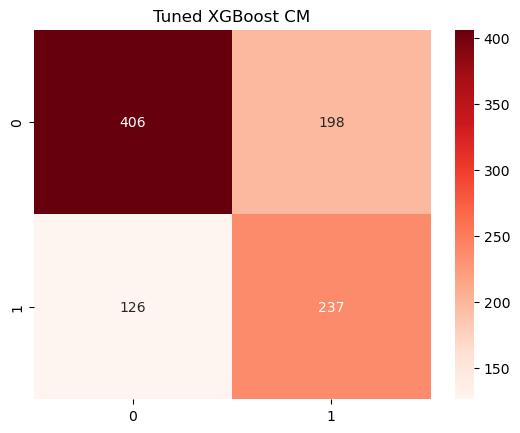

In [99]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds')
plt.title('Tuned XGBoost CM')
plt.show()

In [100]:
joblib.dump(xgb_pipe, 'tuned_xgb_smote_optuna.pkl')
joblib.dump(study, 'optuna_study.pkl')

['optuna_study.pkl']

# Voting Ensemble

In [101]:
from sklearn.ensemble import VotingClassifier

In [102]:
lr_model = joblib.load('tuned_lr_smote.pkl')  # Extract model from pipeline
rf_model = joblib.load('tuned_rf_smote.pkl')
xgb_model = joblib.load('tuned_xgb_smote_optuna.pkl')


In [103]:
voting = VotingClassifier([
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft', weights=[1, 1, 2])
voting.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,None
,flatten_transform,True
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,penalty,'l2'
,dual,False


In [104]:
y_pred_voting = voting.predict(X_test)
y_proba_voting = voting.predict_proba(X_test)[:, 1]
print("\nVoting Report:\n", classification_report(y_test, y_pred_voting))
print(f"Voting AUC: {roc_auc_score(y_test, y_proba_voting):.3f}")
print(f"Voting Acc: {(y_pred_voting == y_test).mean():.3f}")


Voting Report:
               precision    recall  f1-score   support

           0       0.77      0.68      0.72       604
           1       0.56      0.67      0.61       363

    accuracy                           0.68       967
   macro avg       0.67      0.67      0.67       967
weighted avg       0.69      0.68      0.68       967

Voting AUC: 0.751
Voting Acc: 0.676


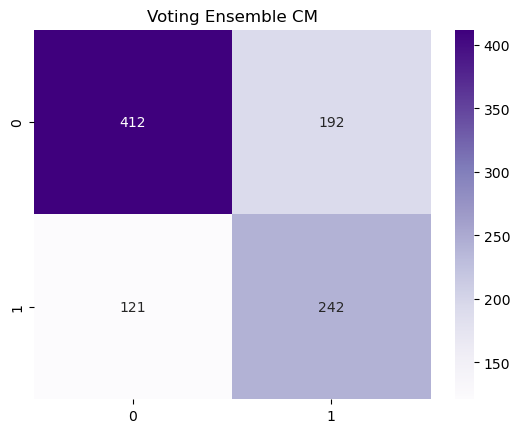

In [105]:
cm_ens = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Purples')
plt.title('Voting Ensemble CM')
plt.show()

In [106]:
joblib.dump(voting, 'prebuilt_voting.pkl')

['prebuilt_voting.pkl']

# Stacking Ensemble

In [107]:
from sklearn.ensemble import StackingClassifier

In [108]:
lr_est = joblib.load('tuned_lr_smote.pkl')
rf_est = joblib.load('tuned_rf_smote.pkl')
xgb_est = joblib.load('tuned_xgb_smote_optuna.pkl')
voting = joblib.load('prebuilt_voting.pkl')

In [109]:
stacking = StackingClassifier([
    ('voting', voting),      # Prebuilt voting as base
    ('lr_base', lr_est),     # Individual bases
    ('rf_base', rf_est),
    ('xgb_base', xgb_est)
], final_estimator=LogisticRegression(random_state=42), cv=5,n_jobs=-1,verbose=1)

In [110]:
stacking.fit(X_train, y_train)

,estimators,"[('voting', ...), ('lr_base', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,1
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,penalty,'l2'


In [111]:
y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)[:, 1]
print("\nStacking Report:\n", classification_report(y_test, y_pred_stack))
print(f"Stacking AUC: {roc_auc_score(y_test, y_proba_stack):.3f}")
print(f"Stacking Acc: {(y_pred_stack == y_test).mean():.3f}")


Stacking Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       604
           1       0.63      0.49      0.55       363

    accuracy                           0.70       967
   macro avg       0.68      0.66      0.66       967
weighted avg       0.69      0.70      0.69       967

Stacking AUC: 0.754
Stacking Acc: 0.702


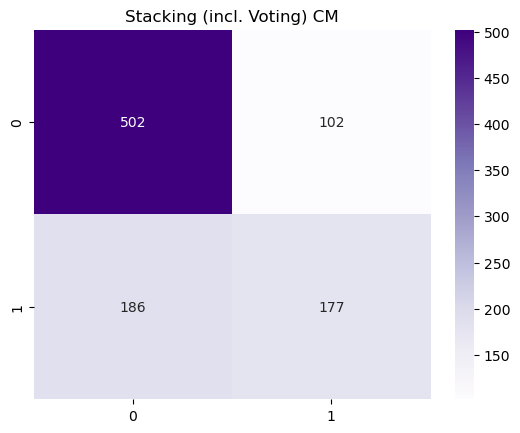

['stacking_with_voting.pkl']

In [112]:
# CM for stacking
cm_stack = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples')
plt.title('Stacking (incl. Voting) CM')
plt.show()

joblib.dump(stacking, 'stacking_with_voting.pkl')

## COMPARISON

                      Model  Test Acc
0          Tuned LR + SMOTE     0.611
1          Tuned RF + SMOTE     0.683
2  Tuned XGB + SMOTE/Optuna     0.665
3           Prebuilt Voting     0.676
4      Stacking (w/ Voting)     0.702


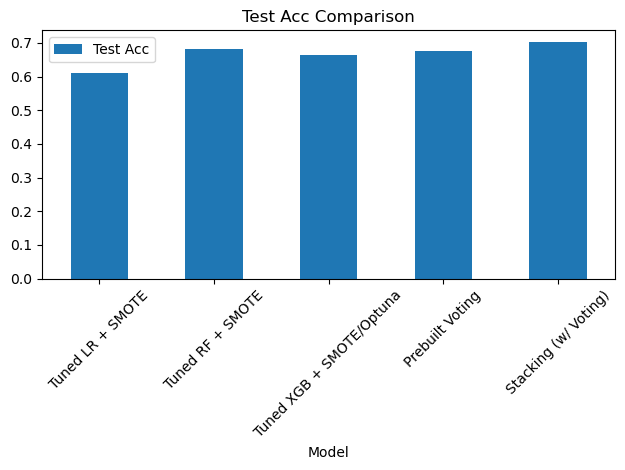

In [113]:
test_accs = {
    'Tuned LR + SMOTE': (y_pred_lr == y_test).mean(),
    'Tuned RF + SMOTE': (y_pred_rf == y_test).mean(),
    'Tuned XGB + SMOTE/Optuna': (y_pred_xgb == y_test).mean(),
    'Prebuilt Voting': (y_pred_voting == y_test).mean(),
    'Stacking (w/ Voting)': (y_pred_stack == y_test).mean()
}

results = pd.DataFrame({
    'Model': list(test_accs.keys()),
    'Test Acc': list(test_accs.values())
}).round(3)
print(results)
results.plot(kind='bar', x='Model', y='Test Acc', title='Test Acc Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()